<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/redes_generativas_adversarias/introducci%C3%B3n_a_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción

Las redes generativas adversarias (GANs, por sus siglas en inglés) son un tipo de modelo de aprendizaje profundo que consiste en dos redes neuronales que trabajan en conjunto para generar datos nuevos y realistas a partir de un conjunto de datos existente.

La primera red, llamada el generador, toma una entrada aleatoria y produce una salida que se parece a los datos de entrenamiento. La segunda red, llamada el discriminador, toma una entrada (ya sea del conjunto de datos real o del generador) y determina si es real o falsa.

El objetivo de la GAN es entrenar al generador para que produzca salidas cada vez más cercanas a los datos de entrenamiento, mientras que el discriminador se entrena para distinguir entre las salidas del generador y los datos de entrenamiento reales.

De esta manera, ambas redes se retroalimentan y mejoran juntas, hasta que el generador es capaz de generar salidas que son indistinguibles de los datos de entrenamiento reales.

Los elementos característicos de una GAN son:

* El generador: Es la red neuronal que produce nuevas salidas basadas en entradas aleatorias.
* El discriminador: Es la red neuronal que determina si una entrada es real o falsa.
* La función de pérdida: Es la métrica que se utiliza para medir el desempeño de la GAN. Generalmente, se utiliza la función de pérdida de entropía cruzada.
* La retroalimentación: Es el proceso por el cual la GAN se entrena a sí misma, mediante la retroalimentación entre el generador y el discriminador.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten

from IPython import display

In [2]:
(X_train, _), _ = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)

In [4]:
def plot_multiple_images(images, n_cols=None, epoch=0):
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    fig = plt.figure(figsize=(n_cols, n_rows))
    fig.suptitle(f"Epochs {epoch}", fontsize="x-large")
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
  
    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

### Generador

El generador es una red neuronal que toma una entrada aleatoria, también conocida como vector latente, y la procesa a través de una serie de capas neuronales para generar una salida que se asemeje a los datos de entrenamiento. En otras palabras, el generador aprende a mapear un espacio de entrada aleatorio a un espacio de salida que contiene datos realistas.

Para lograr esto, el generador utiliza una arquitectura de red neuronal profunda, generalmente con varias capas de neuronas. Cada capa en el generador transforma la entrada de manera que se aproxime cada vez más a la distribución de los datos de entrenamiento. Esto se logra mediante el aprendizaje de representaciones cada vez más complejas a medida que se avanza en las capas.

El objetivo final del generador es generar salidas que sean indistinguibles de los datos de entrenamiento reales.

In [5]:
random_normal_dimensions = 32

generator = Sequential()
generator.add(Dense(64, activation="selu", input_shape=[random_normal_dimensions]))
generator.add(Dense(128, activation="selu"))
generator.add(Dense(28 * 28, activation="sigmoid"))
generator.add(Reshape([28, 28]))

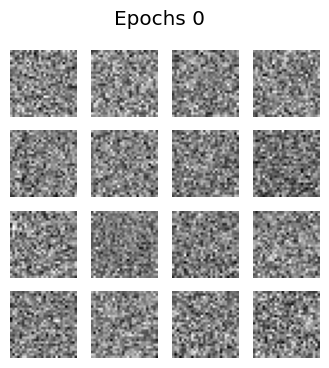

In [6]:
test_noise = tf.random.normal([16, random_normal_dimensions])
test_image = generator(test_noise)
plot_multiple_images(test_image, n_cols=4)

### Discriminador

El discriminador es una red neuronal que se encarga de determinar si una entrada es real o falsa. Esta entrada puede ser tanto un dato real proveniente del conjunto de datos de entrenamiento como una salida generada por el generador. El objetivo del discriminador es distinguir entre las salidas generadas por el generador y los datos de entrenamiento reales.

Para lograr esto, el discriminador también utiliza una arquitectura de red neuronal profunda, generalmente con varias capas de neuronas. Cada capa en el discriminador transforma la entrada de manera que pueda distinguir mejor entre las salidas generadas por el generador y los datos de entrenamiento reales.

El discriminador se entrena utilizando la retroalimentación con el generador. El generador produce salidas que se asemejan a los datos de entrenamiento reales y se las envía al discriminador. El discriminador evalúa si la entrada es real o falsa y produce una probabilidad que indica la confianza que tiene en su respuesta.

In [7]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28, 28]))
discriminator.add(Dense(128, activation="selu"))
discriminator.add(Dense(64, activation="sigmoid"))
discriminator.add(Dense(1, activation="sigmoid"))

In [8]:
gan = Sequential([generator, discriminator])

La función de pérdida es diferente para el generador y el discriminador en una GAN. Para el generador, la función de pérdida se basa en la capacidad del discriminador para distinguir entre las salidas generadas por el generador y los datos de entrenamiento reales. Es decir, la función de pérdida mide la capacidad del generador para engañar al discriminador, lo que se traduce en una reducción en la capacidad del discriminador para distinguir entre las salidas generadas y los datos reales.

Por otro lado, la función de pérdida del discriminador mide su capacidad para distinguir entre las salidas generadas por el generador y los datos de entrenamiento reales. El discriminador se entrena para maximizar su tasa de acierto al distinguir entre estas dos clases de datos, lo que se traduce en una reducción en la capacidad del generador para producir salidas que puedan ser identificadas como falsas.

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

El proceso de entrenamiento se lleva a cabo en varias etapas, y cada etapa se compone de los siguientes pasos:

1. Se alimenta al generador con un vector de ruido (también llamado "semilla"), que es un conjunto de números aleatorios tomados de una distribución gaussiana o uniforme. El generador utiliza este vector para producir una salida generada.

2. Se alimenta al discriminador con una entrada, que puede ser una salida generada por el generador o un dato real de entrenamiento del conjunto de datos. El discriminador evalúa la entrada y produce una probabilidad que indica la confianza que tiene en su respuesta.

3. Se calcula la función de pérdida para el generador y el discriminador. La función de pérdida del generador se basa en la capacidad del discriminador para distinguir entre las salidas generadas por el generador y los datos de entrenamiento reales. La función de pérdida del discriminador mide su capacidad para distinguir entre las salidas generadas por el generador y los datos de entrenamiento reales.

4. Se ajustan los pesos de ambas redes mediante la retropropagación del error. El objetivo es minimizar la función de pérdida del generador y del discriminador.

5. Se repiten los pasos 1 a 4 varias veces, alternando el entrenamiento del generador y del discriminador en cada iteración.

6. Finalmente, una vez que el entrenamiento ha finalizado, se utiliza el generador para generar nuevas muestras que se parecen a los datos de entrenamiento reales.

In [10]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Época {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Fase 1 - Discriminaodr
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Fase 2 - Generador
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, generator_labels)

    plot_multiple_images(fake_images, 8, epoch)
    plt.show()

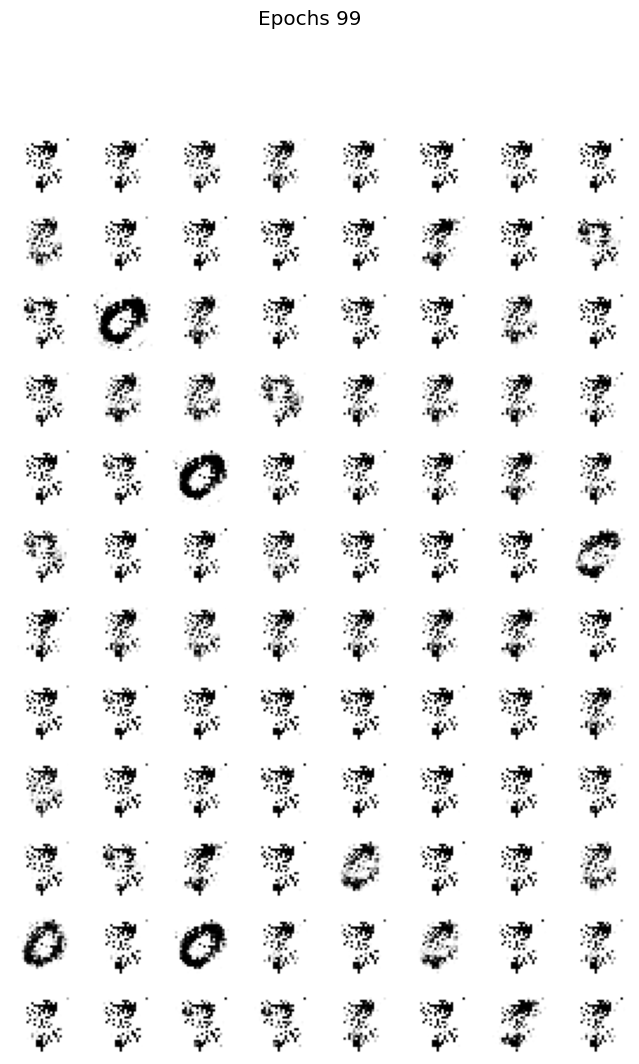

CPU times: user 16min 7s, sys: 57.5 s, total: 17min 5s
Wall time: 16min 33s


In [11]:
%%time
train_gan(gan, dataset, random_normal_dimensions, n_epochs=100)

**Referencias**

* https://proceedings.neurips.cc/paper_files/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf
* https://arxiv.org/pdf/1511.06434.pdf
* https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf
* https://arxiv.org/pdf/1710.10196.pdf